🎯 1. WHAT IS THE AIM OF THIS PROJECT?
The goal is to analyze why some taxi orders fail in the Gett platform and uncover patterns behind those failures.

🧾 Business Context
Gett is a ride-hailing platform, similar to Uber or Ola. Customers place orders for rides via an app. These orders go through a matching system that connects them with drivers. However, not all orders succeed — some are cancelled or rejected.

📌 You are being asked to:
Investigate the failed orders — find out:

Why they failed

When they failed

How they failed

And where failures are concentrated

This helps the company improve:

Driver allocation

ETA predictions

Customer satisfaction

Platform reliability

🧰 2. WHAT DATA ARE YOU GIVEN?
You are given two CSV files:

🔹 data_orders.csv
Each row = 1 ride order
Columns:

Column Name	Description
order_datetime	When the order was made
origin_longitude / latitude	Where the order was placed
m_order_eta	Estimated Time of Arrival (ETA) of a car
order_gk	Unique ID of the order
order_status_key	Outcome of the order (4 = client canceled, 9 = rejected by system)
is_driver_assigned_key	1 if a driver was assigned, 0 otherwise
cancellation_time_in_seconds	Time before cancellation happened (if cancelled)

🔹 data_offers.csv
Just maps offers to orders:

order_gk	offer_id

This file is mostly optional for core analysis — used if you want to explore which orders got offers.

🧠 3. WHAT IS REQUIRED TO DO?
You're asked to perform data analysis and visualizations to uncover why and how orders fail.

You’ll answer 4 main questions:
✅ Q1: What are the reasons for failure?
Build a distribution plot of failed orders categorized as:

Cancelled before driver assigned

Cancelled after driver assigned

Rejected by the system

🎯 Goal: See which failure type is most common.

✅ Q2: When do failures happen the most?
Plot failed orders by hour of day (0 to 23)

See if any failure type spikes at specific hours (e.g. morning rush?)

🎯 Goal: Identify high-risk time windows for failures.

✅ Q3: How long do cancellations take, with and without driver?
Compare average time to cancellation:

When driver was assigned vs not

By hour of day

🎯 Goal: See if users cancel faster when no driver is assigned, and how this changes through the day.

✅ Q4: Does ETA impact failure?
Plot average ETA (Estimated Time of Arrival) by hour.

🎯 Goal: Understand whether longer ETA (wait times) during certain hours may lead to more cancellations.

⭐ BONUS: Where do most failures happen?
Use GPS data with H3 (hexagons) and Folium (maps) to:

Count how many geographic hexes contain 80% of all orders

Visualize them colored by number of failures

🎯 Goal: Spot problem areas on the map to optimize driver coverage.

🔍 4. WHAT TO OBSERVE OR PREDICT?
You're not predicting right now — you’re doing exploratory data analysis (EDA).
But your observations should answer:

Business Question	What to observe
What’s the most common reason for failure?	Count of each failure type
When do failures spike?	Hourly trend of failures
Does driver assignment affect cancellations?	Compare cancel time with/without driver
Does ETA affect failures?	Long ETA → more client cancellations?
Where are failures concentrated?	Locations using hexbin maps

📈 5. DELIVERABLE FORMAT
You are expected to present:

Well-structured Python code (ideally in Jupyter Notebook)

Cleaned and merged data

Well-labeled plots
a
Bullet-pointed or Markdown summary of insights for each task

🚀 Summary
✅ Task	🔍 You Analyze...
Q1: Failure reasons	Cancellation before/after driver, system reject
Q2: Time-based trend	Failures by hour
Q3: Time-to-cancel	With/without driver, by hour
Q4: ETA by hour	Do higher ETAs correlate with failures?
BONUS: Location clustering	Spatial hotspot of failed orders



In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [7]:

data_orders_df = pd.read_csv('data_orders.csv')
data_offers_df = pd.read_csv('data_offers.csv')


In [8]:
data_offers_df.head()


,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [9]:
data_orders_df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [10]:
data_offers_df.describe()

,order_gk,offer_id
count,3.343630e+05,3.343630e+05
mean,3.000602e+12,3.000515e+11
std,2.431638e+07,5.276821e+05
min,3.000551e+12,3.000506e+11
25%,3.000585e+12,3.000511e+11
50%,3.000596e+12,3.000516e+11
75%,3.000625e+12,3.000520e+11
max,3.000633e+12,3.000524e+11


In [11]:
data_orders_df.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
count,10716.000000,10716.000000,2814.000000,1.071600e+04,10716.000000,10716.000000,7307.000000
mean,-0.964323,51.450541,441.415423,3.000598e+12,5.590612,0.262598,157.892021
std,0.022818,0.011984,288.006379,2.396261e+07,2.328845,0.440066,213.366963
min,-1.066957,51.399323,60.000000,3.000550e+12,4.000000,0.000000,3.000000
25%,-0.974363,51.444643,233.000000,3.000583e+12,4.000000,0.000000,45.000000
50%,-0.966386,51.451972,368.500000,3.000595e+12,4.000000,0.000000,98.000000
75%,-0.949605,51.456725,653.000000,3.000623e+12,9.000000,1.000000,187.500000
max,-0.867088,51.496169,1559.000000,3.000633e+12,9.000000,1.000000,4303.000000


In [12]:
data_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [13]:
data_orders_df.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

In [14]:
df_orders = data_orders_df.copy()

In [15]:
# when the 'm_order_eta' is not missing and driver is assigned
cnt = 0
for row in df_orders.iterrows():
    if pd.notna(row[1]['m_order_eta']) and row[1]['is_driver_assigned_key'] == 1:
        cnt += 1
print(cnt)


2814


<Axes: xlabel='is_driver_assigned_key', ylabel='count'>

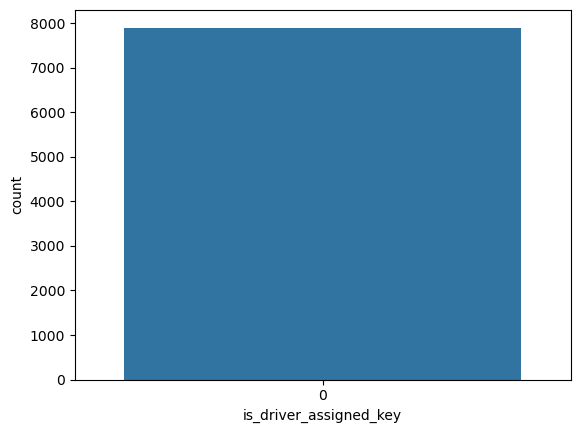

In [16]:
sns.countplot(df_orders[df_orders['m_order_eta'].isna()], x='is_driver_assigned_key')

In [17]:
df_orders['eta_missing'] = df_orders['m_order_eta'].isna()

# Cross-tab: rows = driver assigned, columns = eta missing
crosstab_result = pd.crosstab(
    df_orders['is_driver_assigned_key'],
    df_orders['eta_missing'],
    rownames=['Driver Assigned'],
    colnames=['ETA Missing']
)

print(crosstab_result)


ETA Missing      False  True 
Driver Assigned              
0                    0   7902
1                 2814      0


so when the driver was not assined the eta is null because could not estimate the time of arrival

In [18]:
df_orders['eta_missing'] = df_orders['m_order_eta'].isna()

# Cross-tab: rows = driver assigned, columns = eta missing
crosstab_result = pd.crosstab(
    df_orders['order_status_key'],
    df_orders['eta_missing'],
    rownames=['order rejected by'],
    colnames=['ETA Missing']
)

print(crosstab_result)


ETA Missing        False  True 
order rejected by              
4                   2811   4496
9                      3   3406


Row 4 = Orders where the client cancelled:

2811 had ETA (i.e., ETA was generated before they cancelled)

4496 did not have ETA (likely cancelled before a driver was assigned)

Row 9 = Orders rejected by the system:

3 had ETA (very rare — probably assigned before being rejected)

3406 did not have ETA — almost all system rejections never reached a stage where ETA was calculated.

In [19]:
df_orders['m_order_eta'] = df_orders['m_order_eta'].fillna(-1)

In [20]:
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,eta_missing
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,False
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0,True
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,False
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,False
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,NaN,True


In [21]:
df_orders.isnull().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                         0
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
eta_missing                         0
dtype: int64

In [22]:
df_orders['cancelletion_missing'] = df_orders['cancellations_time_in_seconds'].isna()

# Cross-tab: rows = driver assigned, columns = eta missing
crosstab_result = pd.crosstab(
    df_orders['order_status_key'],
    df_orders['cancelletion_missing'],
    rownames=['order rejected by'],
    colnames=['cancelletion_missing']
)

print(crosstab_result)


cancelletion_missing  False  True 
order rejected by                 
4                      7307      0
9                         0   3409


so the cancellation time is missing when the order was rejected by the system

In [23]:
# Fill cancellation time with 0 only for system-rejected orders (status 9)
df_orders.loc[df_orders['order_status_key'] == 9, 'cancellations_time_in_seconds'] = 0


In [24]:
df_orders.isnull().sum()

order_datetime                   0
origin_longitude                 0
origin_latitude                  0
m_order_eta                      0
order_gk                         0
order_status_key                 0
is_driver_assigned_key           0
cancellations_time_in_seconds    0
eta_missing                      0
cancelletion_missing             0
dtype: int64

In [25]:
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,eta_missing,cancelletion_missing
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,False,False
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0,True,False
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,False,False
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,False,False
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,0.0,True,True


In [26]:
df_orders.drop(['eta_missing','cancelletion_missing'], axis=1, inplace=True)

In [27]:
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,0.0


In [28]:
# Extract hour from datetime
df_orders['order_hour'] = pd.to_datetime(df_orders['order_datetime']).dt.hour

# Define failure type based on status and driver assignment
def classify_failure(row):
    if row['order_status_key'] == 9:
        return 'System Rejected'
    elif row['order_status_key'] == 4:
        if row['is_driver_assigned_key'] == 1:
            return 'Cancelled After Driver Assigned'
        else:
            return 'Cancelled Before Driver Assigned'
    else:
        return 'Other'

df_orders['failure_type'] = df_orders.apply(classify_failure, axis=1)


C:\Users\Saikiran\AppData\Local\Temp\ipykernel_19704\3611929439.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orders['order_hour'] = pd.to_datetime(df_orders['order_datetime']).dt.hour


 Let's now compare order_status_key and cancellations_time_in_seconds to understand how long it takes for an order to get canceled or rejected, based on the status.



C:\Users\Saikiran\AppData\Local\Temp\ipykernel_19704\2229189612.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='status_label', y='cancellations_time_in_seconds', palette='Set2')


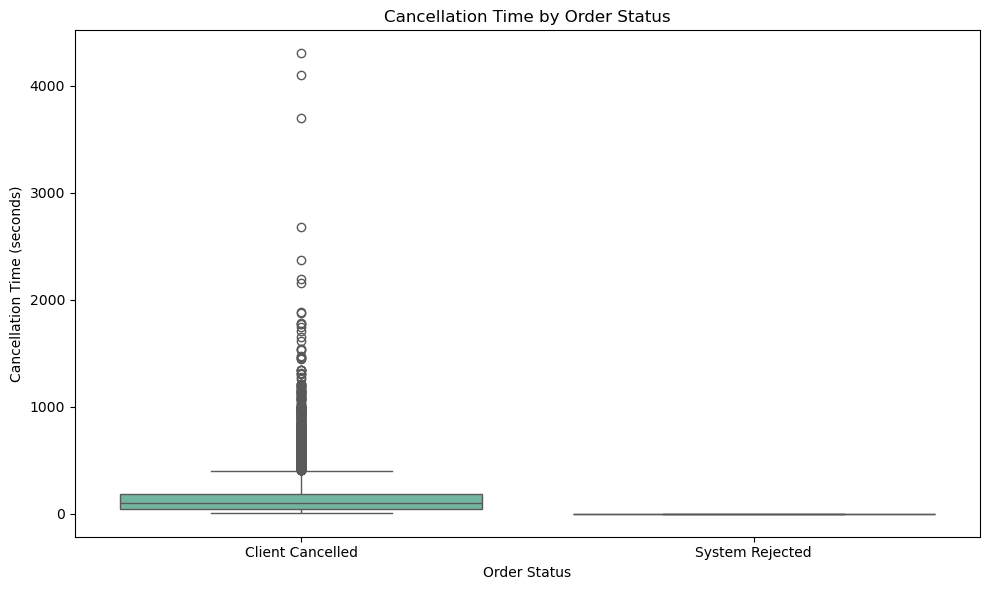

In [31]:
subset = df_orders[df_orders['order_status_key'].isin([4, 9])]
status_map = {
    4: 'Client Cancelled',
    9: 'System Rejected'
}

subset['status_label'] = subset['order_status_key'].map(status_map)

plt.figure(figsize=(10, 6))
sns.boxplot(data=subset, x='status_label', y='cancellations_time_in_seconds', palette='Set2')
plt.title("Cancellation Time by Order Status")
plt.xlabel("Order Status")
plt.ylabel("Cancellation Time (seconds)")
plt.tight_layout()
plt.show()


 mean cancellation time per status

In [32]:
avg_cancel_time = subset.groupby('status_label')['cancellations_time_in_seconds'].mean().round(2)
print(avg_cancel_time)


status_label
Client Cancelled    157.89
System Rejected       0.00
Name: cancellations_time_in_seconds, dtype: float64


Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?




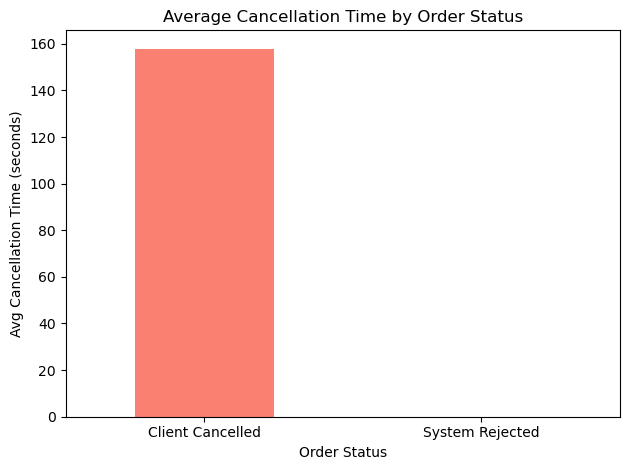

In [33]:

avg_cancel_time.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title("Average Cancellation Time by Order Status")
plt.xlabel("Order Status")
plt.ylabel("Avg Cancellation Time (seconds)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

It looks like system is rejecting the client requests when there are no drivers available

Goal: See if users cancel faster when no driver is assigned, and how this changes through the day.

✅ Q4: Does ETA impact failure? Plot average ETA (Estimated Time of Arrival) by hour.

In [34]:
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour,failure_type
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,Cancelled After Driver Assigned
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0,20,Cancelled Before Driver Assigned
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,Cancelled After Driver Assigned
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,Cancelled After Driver Assigned
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,0.0,21,System Rejected


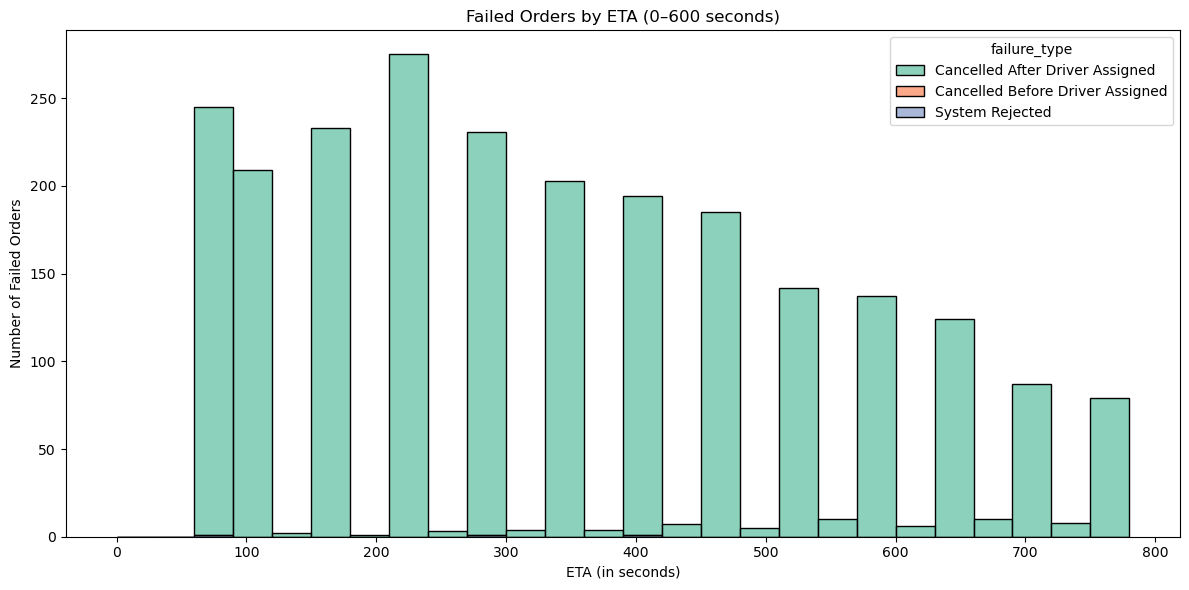

In [35]:

plt.figure(figsize=(12, 6))
bins = np.arange(0, 810, 30)  # 30s bins up to 600s

sns.histplot(
    data=failed_orders,
    x='m_order_eta',
    hue='failure_type',
    multiple='stack',
    bins=bins,
    palette='Set2'
)
plt.title("Failed Orders by ETA (0–600 seconds)")
plt.xlabel("ETA (in seconds)")
plt.ylabel("Number of Failed Orders")
plt.tight_layout()
plt.show()


when ever the eta estimated time of arrival is large the order is being cancelled after driver is assigned

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?


*   List item
*   List item



In [36]:
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour,failure_type
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,Cancelled After Driver Assigned
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0,20,Cancelled Before Driver Assigned
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,Cancelled After Driver Assigned
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,Cancelled After Driver Assigned
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,0.0,21,System Rejected


Plot the distribution of average ETA by hours. How can this plot be explained?

Q1: What are the reasons for failure?
Build a distribution plot of failed orders categorized as:

Cancelled before driver assigned

Cancelled after driver assigned

Rejected by the system

🎯 Goal: See which failure type is most common.


Text(0.5, 1.0, 'Distribution of Failed Orders by Failure Type')

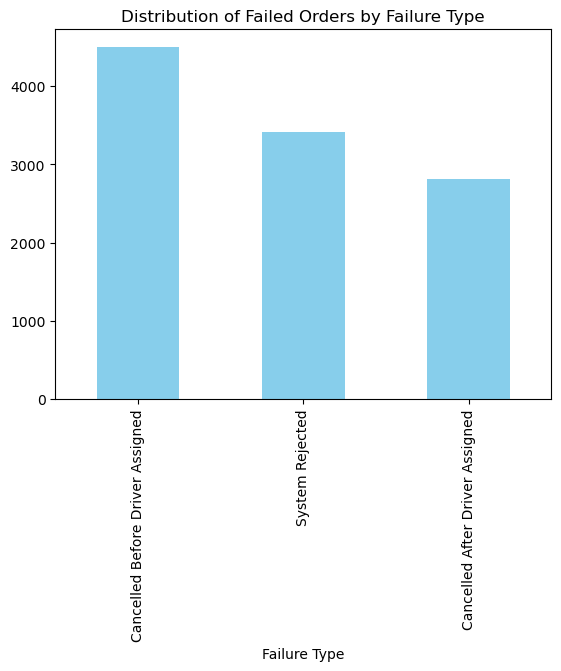

In [96]:
failed_orders['failure_type'].value_counts().plot(kind='bar', color='skyblue')
plt.savefig('failed_orders_by_type.png', dpi=300, bbox_inches='tight')
plt.xlabel("Failure Type")
plt.title("Distribution of Failed Orders by Failure Type")

cancellation before driver assigned is most common failure type

Q2: When do failures happen the most?
Plot failed orders by hour of day (0 to 23)

See if any failure type spikes at specific hours (e.g. morning rush?)

🎯 Goal: Identify high-risk time windows for failures.

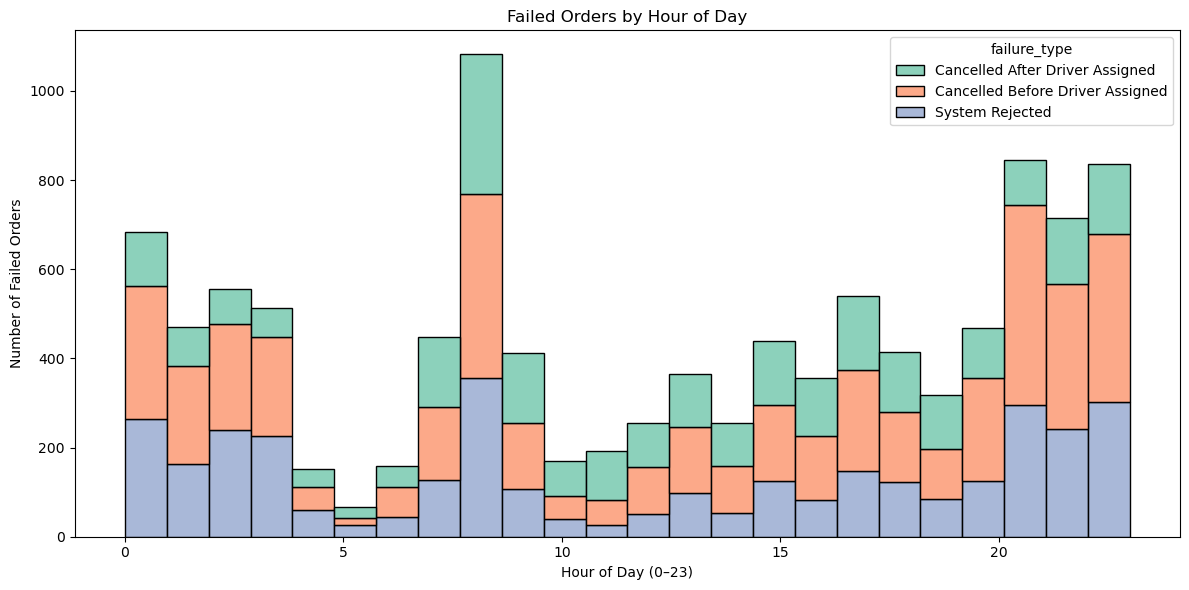

In [53]:
failed_orders = df_orders[df_orders['failure_type'] != 'Other']
plt.figure(figsize=(12, 6))
sns.histplot(
    data=failed_orders,
    x='order_hour',
    hue='failure_type',
    multiple='stack',
    bins=24,
    palette='Set2'
)
plt.title("Failed Orders by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Failed Orders")
plt.tight_layout()
plt.savefig('failed_orders_by_hour.png')
plt.show()


Many order are cancelled in 0-4 hours, which is early morning hour and later 20th hour.
8 th hour which is a morning rush hour indicated all the drivers were either already assigned or unavailability of drivers.


 Q3: How long do cancellations take, with and without driver?
Compare average time to cancellation:

When driver was assigned vs not

By hour of day

🎯 Goal: See if users cancel faster when no driver is assigned, and how this changes through the day.


Text(0.5, 1.0, 'Average Cancellation Time by Hour of Day')

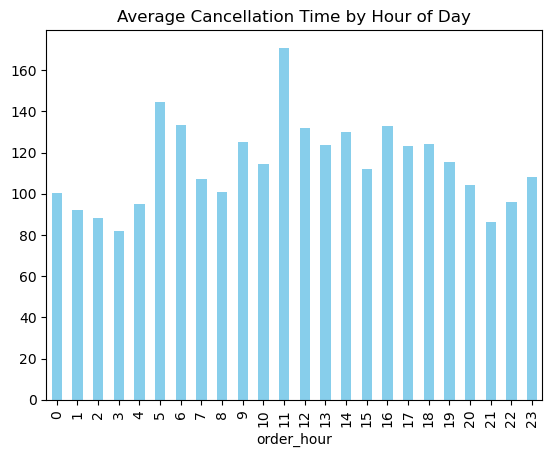

In [56]:
avg_cancel_time_by_hour = failed_orders.groupby('order_hour')['cancellations_time_in_seconds'].mean().round(2)
avg_cancel_time_by_hour.plot(kind='bar', color='skyblue')
plt.title("Average Cancellation Time by Hour of Day")  

In [59]:
df_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour,failure_type
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,Cancelled After Driver Assigned
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0,20,Cancelled Before Driver Assigned
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,Cancelled After Driver Assigned
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,Cancelled After Driver Assigned
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,0.0,21,System Rejected


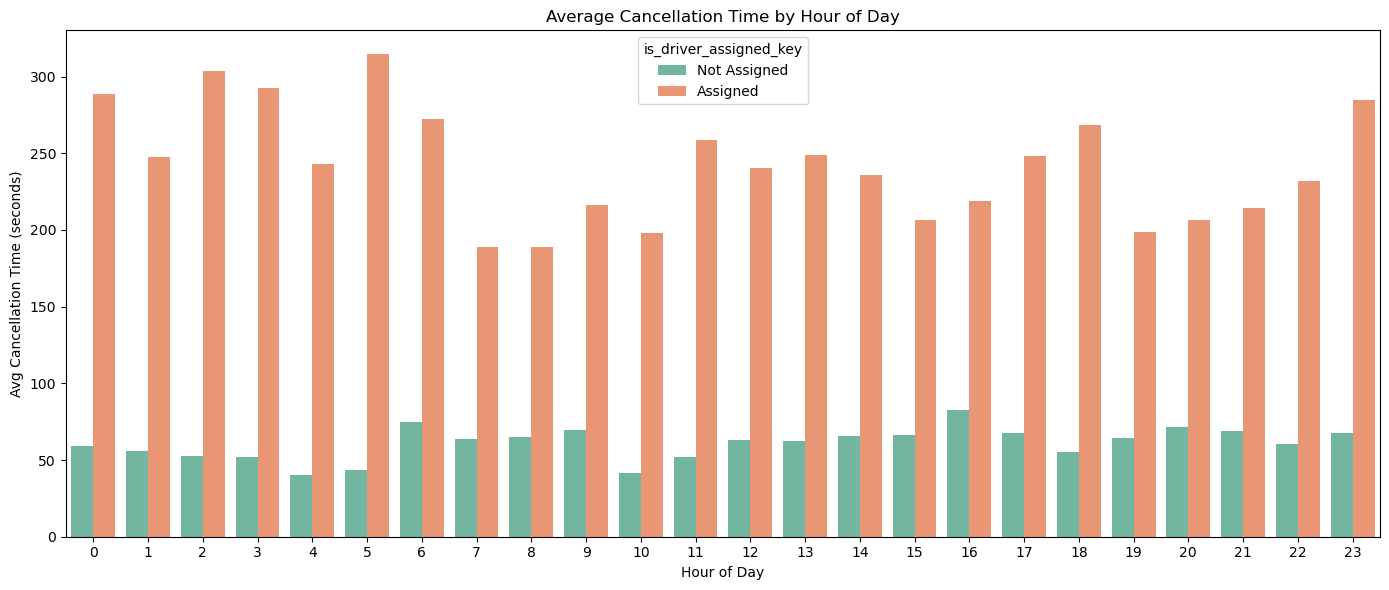

In [64]:
# Group by hour and failure_type
driver_assigned_map = {
    0: 'Not Assigned',
    1: 'Assigned'
}
avg_cancel_time = (
    failed_orders.groupby(['order_hour', 'is_driver_assigned_key'])['cancellations_time_in_seconds']
    .mean()
    .reset_index()
)
avg_cancel_time['is_driver_assigned_key'] = avg_cancel_time['is_driver_assigned_key'].map(driver_assigned_map)

# Plot with hue
plt.figure(figsize=(14, 6))
sns.barplot(
    data=avg_cancel_time,
    x='order_hour',
    y='cancellations_time_in_seconds',
    hue='is_driver_assigned_key',
    palette='Set2'
)
plt.title("Average Cancellation Time by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Cancellation Time (seconds)")
plt.tight_layout()
plt.savefig('avg_cancel_time_by_hour.png')
plt.show()


User cancel faster when driver is not assigned

In [65]:
avg_eta = subset.groupby('order_hour')['m_order_eta'].mean().round(2)


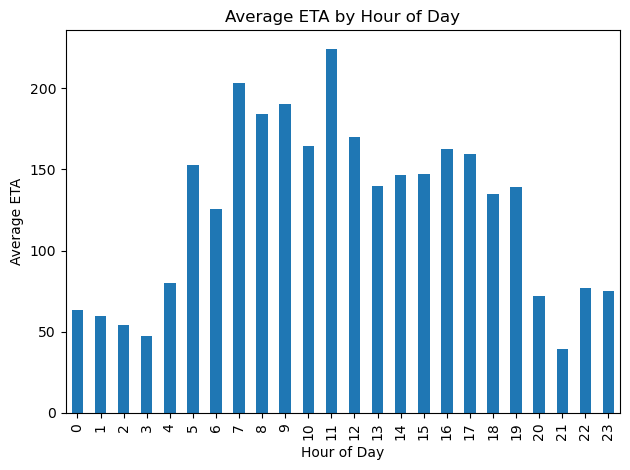

In [46]:
avg_eta.plot(kind='bar')
plt.title("Average ETA by Hour of Day")
plt.xlabel("Hour of Day")   
plt.ylabel("Average ETA")
plt.tight_layout()
plt.savefig('avg_eta_by_hour.png')
plt.show()

There is higher eta between 7-10 likely morning rush
in mid day hours there is average number of orders are observered
Less eta after 20 till 4

the the average eta has been seen increased between hours 7-10 hours due to morning rush
it gradually decreases after 16th hour 

Hours with high ETA (e.g., 7–11 AM) often correlate with higher cancellations, indicating operational strain.

Evening spike (8–9 PM) in failed orders despite lower ETA could point to demand–supply mismatch or driver unavailability.

Midnight spike (0h) in failures with relatively low ETA is unusual — possibly due to platform/system constraints or scheduled orders failing

BONUS: Where do most failures happen?
Use GPS data with H3 (hexagons) and Folium (maps) to:

Count how many geographic hexes contain 80% of all orders

Visualize them colored by number of failures

🎯 Goal: Spot problem areas on the map to optimize driver coverage.

In [72]:
failed_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour,failure_type
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18,Cancelled After Driver Assigned
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0,20,Cancelled Before Driver Assigned
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12,Cancelled After Driver Assigned
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13,Cancelled After Driver Assigned
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,0.0,21,System Rejected


In [101]:
import folium
import h3
import pandas as pd

# Set H3 resolution (6 = city-level granularity)
resolution = 6

# Convert lat/lon to H3 hex indexes
failed_orders['hex'] = failed_orders.apply(
    lambda row: h3.latlng_to_cell(row['origin_latitude'], row['origin_longitude'], resolution),
    axis=1
)

# Count failed orders per hex
hex_counts = failed_orders['hex'].value_counts().reset_index()
hex_counts.columns = ['hex', 'failures']

# Calculate cumulative failure coverage
hex_counts['cum_sum'] = hex_counts['failures'].cumsum()
total_failures = hex_counts['failures'].sum()
hex_counts['cum_perc'] = hex_counts['cum_sum'] / total_failures

# Select hexes that account for top 80% of failures
top_hexes = hex_counts[hex_counts['cum_perc'] <= 0.8]

# Helper: convert H3 hex index to [lat, lon] polygon
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)
    return [[lat, lon] for lat, lon in boundary]

# Initialize map centered at mean failure location
map_center = [
    failed_orders['origin_latitude'].mean(),
    failed_orders['origin_longitude'].mean()
]
m = folium.Map(
    location=map_center,
    zoom_start=11,
    tiles='OpenStreetMap',
    attr='Map data © OpenStreetMap contributors'
)

# Plot top failure hexes on the map
for _, row in top_hexes.iterrows():
    hex_poly = h3_to_polygon(row['hex'])
    folium.Polygon(
        locations=hex_poly,
        color='crimson',
        fill=True,
        fill_opacity=0.65,
        weight=1.5,
        tooltip=f"{row['failures']} failures"
    ).add_to(m)

# Save the interactive map
m.save("failure_hotspots.html")
print("✅ Map saved as 'failure_hotspots.html'")


✅ Map saved as 'failure_hotspots.html'


In [95]:
print(f"Total failure hexes: {len(hex_counts)}")
print(f"Top 80% failure hexes: {len(top_hexes)}")
print(top_hexes.head())


Total failure hexes: 7
Top 80% failure hexes: 1
               hex  failures  cum_sum  cum_perc
0  86195d2b7ffffff      7249     7249  0.676465


**Q1: What are the reasons for failure?**
Cancelled Before Driver Assigned is the most common failure type, accounting for approximately 4,500 failed orders. This is followed by System Rejected orders at around 3,500 cases, and Cancelled After Driver Assigned at approximately 2,800 cases.

The dominance of pre-assignment cancellations suggests that customers are losing patience during the initial matching phase, likely due to long wait times or lack of available drivers in their area.

**Q2: When do failures happen the most?**
Failed orders show distinct temporal patterns throughout the day:

Morning rush hour (around 8 AM) experiences the highest failure spike, with over 1,000 total failed orders

Evening peak hours (7-9 PM) also show elevated failure rates of 800+ orders

Early morning hours (4-6 AM) have the lowest failure rates

Late evening hours (10 PM-midnight) maintain moderately high failure levels

The morning rush hour represents the most critical time window for service reliability issues.

**Q3: How long do cancellations take, with and without driver?**
There's a significant difference in cancellation timing based on driver assignment status:

Orders with assigned drivers take much longer to cancel, averaging 200-300+ seconds across most hours

Orders without assigned drivers cancel much faster, typically within 40-80 seconds

Peak cancellation times for assigned drivers occur during early morning hours (midnight-6 AM), reaching over 310 seconds

The pattern suggests customers wait longer when they know a driver is coming, but cancel quickly when no driver is assigned

**Q4: Does ETA impact failure?**
Average ETA shows strong correlation with business hours and potentially with failure patterns:

Lowest ETAs occur during early morning hours (40-60 seconds)

Peak ETA reaches approximately 220+ seconds around 11 AM

Business hours (6 AM-6 PM) consistently show higher ETAs (150-220 seconds)

Evening hours see ETAs drop to around 70-140 seconds

The correlation between high ETA periods and failure spikes (particularly during morning rush) suggests that longer estimated wait times contribute to higher cancellation rates.

Key Business Insights
Critical Issues:

Pre-assignment cancellations dominate failures, indicating insufficient driver availability during matching

Morning rush hour represents the highest risk period for service disruption

Extended ETAs during business hours likely contribute to customer frustration and cancellations

**Recommendations:**

Improve driver allocation algorithms during peak hours (8 AM, 7-9 PM)

Implement dynamic pricing or incentives to increase driver availability during high-demand periods

Enhance ETA accuracy and communication to manage customer expectations

Focus on reducing initial matching time to prevent pre-assignment cancellations

**Business Implications**
*Critical Hotspot Identification:*
The data reveals that Gett's failure problem is not spread across the city but is instead highly concentrated in one specific geographic area. This represents both a challenge and an opportunity:

*Challenges:*

Severe service reliability issues in the primary hotspot area

Potential driver shortage or inefficient matching in this specific location

Customer experience degradation concentrated in one zone

*Opportunities:*
Targeted intervention can address the majority of platform failures

Resource optimization by focusing driver allocation efforts on one key area

High ROI potential since fixing one location impacts 67.6% of all failures